In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score, silhouette_samples

from silhouette_graphs import silhouette_graphs
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
hikes = pd.read_csv('../data/wta-parks-data.csv', index_col=0, sep='\t')

In [112]:
hikes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3251 entries, 0 to 3411
Data columns (total 35 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   name                                                       3251 non-null   object 
 1   url                                                        3251 non-null   object 
 2   length                                                     2149 non-null   float64
 3   highest point                                              1717 non-null   float64
 4   gain                                                       2014 non-null   float64
 5   lat                                                        2452 non-null   float64
 6   lon                                                        2452 non-null   float64
 7   pass: Discover Pass                                        3251 non-null   int64  
 8   pass: Na

# NLP

In [113]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(hikes['description'])
vocab = np.array(sorted(tfidf.vocabulary_))
V = tfidf_matrix

## NMF

In [22]:
n_comps = np.arange(1,30)
error = np.zeros(n_comps.shape)
for n in n_comps:
    nmf = NMF(n_components=n)
    nmf.fit(V)
    W = nmf.transform(V)
    H = nmf.components_
    error[n-1] = nmf.reconstruction_err_


Text(0, 0.5, 'Reconstruction Error')

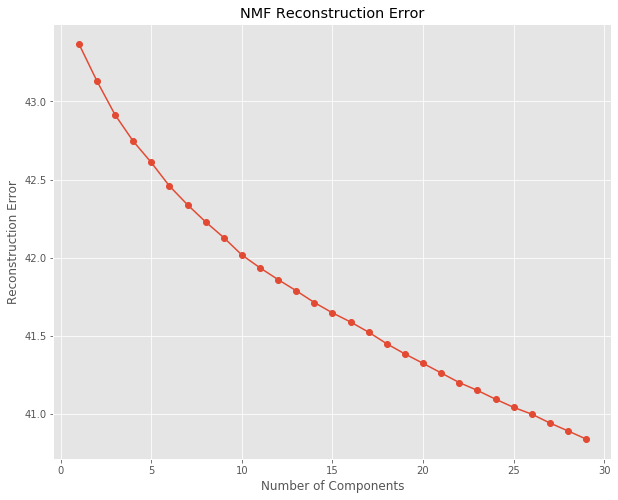

In [23]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(n_comps, error, marker='o')
ax.set_title('NMF Reconstruction Error')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Reconstruction Error')

In [153]:
nmf = NMF(n_components=3)
nmf.fit(V)
W = nmf.transform(V)
H = nmf.components_

In [158]:
for idx, topic in enumerate(H):
    print(vocab[np.argsort(-topic)[:15]])

['trail' 'creek' 'road' 'miles' 'river' 'mile' 'forest' 'hike' 'mountain'
 'park' 'views' 'area' 'loop' 'right' 'way']
['lake' 'trail' 'lakes' 'miles' 'pass' 'junction' 'mile' 'feet' 'hike'
 'forest' 'll' 'trailhead' 'views' 'way' 'meadows']
['gear' 'required' 'experience' 'summit' 'peak' 'scramble' 'finding'
 'expertise' 'climbing' 'route' 'cascades' 'recommended' 'mountain'
 'class' 'north']


In [160]:
technical = (np.argmax(W, axis=1) == 2).astype(int)

## Clustering

In [123]:
cluster = KMeans(n_clusters=2)
cluster.fit(tfidf_matrix)
centroids = cluster.cluster_centers_

In [124]:
for idx, topic in enumerate(centroids):
    print(vocab[np.argsort(-topic)[:15]])

['required' 'trail' 'gear' 'experience' 'park' 'peak' 'area' 'scramble'
 'summit' 'expertise' 'finding' 'route' 'trails' 'mountain' 'climbing']
['trail' 'lake' 'creek' 'miles' 'mile' 'road' 'hike' 'mountain' 'forest'
 'views' 'river' 'ridge' 'feet' 'way' 'trailhead']


In [134]:
cluster = KMeans(n_clusters=4)
cluster.fit(tfidf_matrix)
centroids = cluster.cluster_centers_

In [135]:
for idx, topic in enumerate(centroids):
    print(vocab[np.argsort(-topic)[:15]])

['trump' 'van' 'falls' 'comet' 'mildred' 'rainier' 'stevens' 'feet'
 'mount' 'creek' 'bloucher' 'upstream' 'sluiskin' 'churning' 'trail']
['trail' 'lake' 'creek' 'miles' 'mile' 'road' 'hike' 'views' 'forest'
 'mountain' 'river' 'park' 'area' 'ridge' 'way']
['required' 'gear' 'experience' 'scramble' 'expertise' 'finding'
 'climbing' 'summit' 'peak' 'route' 'recommended' 'cascades' 'near'
 'highway' '90']
['tiger' 'trail' 'tmt' 'mountain' 'poo' 'west' 'grade' 'railroad' 'point'
 'hike' 'south' 'high' 'trails' 'line' 'road']


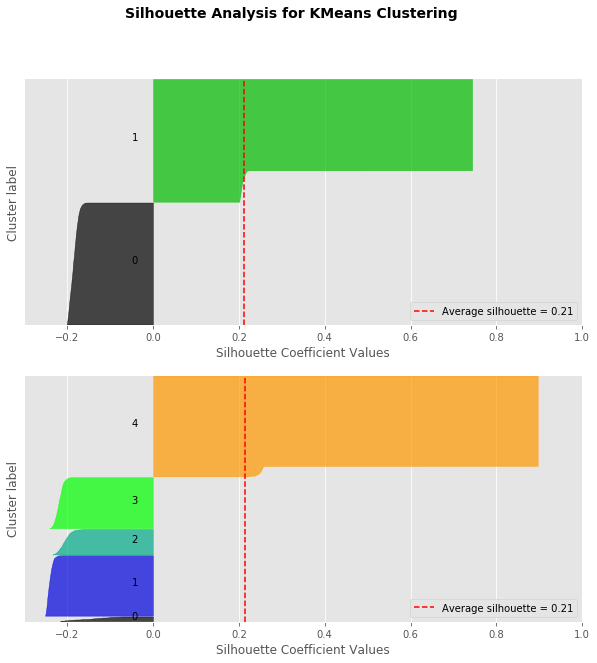

In [85]:
fig, sil_scores = silhouette_graphs(tfidf_matrix, [2, 5])

fig.show()

fig.savefig('../images/text_cluster_silhouette.png', dpi=300, bbox_inches='tight')

In [94]:
technical = np.argmin(cluster.transform(tfidf_matrix), axis=1)
technical = (technical == 2).astype(int)


In [161]:
hikes['technical'] = technical

In [162]:
hikes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3251 entries, 0 to 3411
Data columns (total 35 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   name                                                       3251 non-null   object 
 1   url                                                        3251 non-null   object 
 2   length                                                     2149 non-null   float64
 3   highest point                                              1717 non-null   float64
 4   gain                                                       2014 non-null   float64
 5   lat                                                        2452 non-null   float64
 6   lon                                                        2452 non-null   float64
 7   pass: Discover Pass                                        3251 non-null   int64  
 8   pass: Na

In [163]:
hikes.to_csv('../data/wta-parks-data.csv', sep='\t')

In [167]:
hikes_scatter = hikes[(hikes['length'] < 301) & (hikes['drive distance'] < 1000)].iloc[:,[2,3,4,28,30,34]]

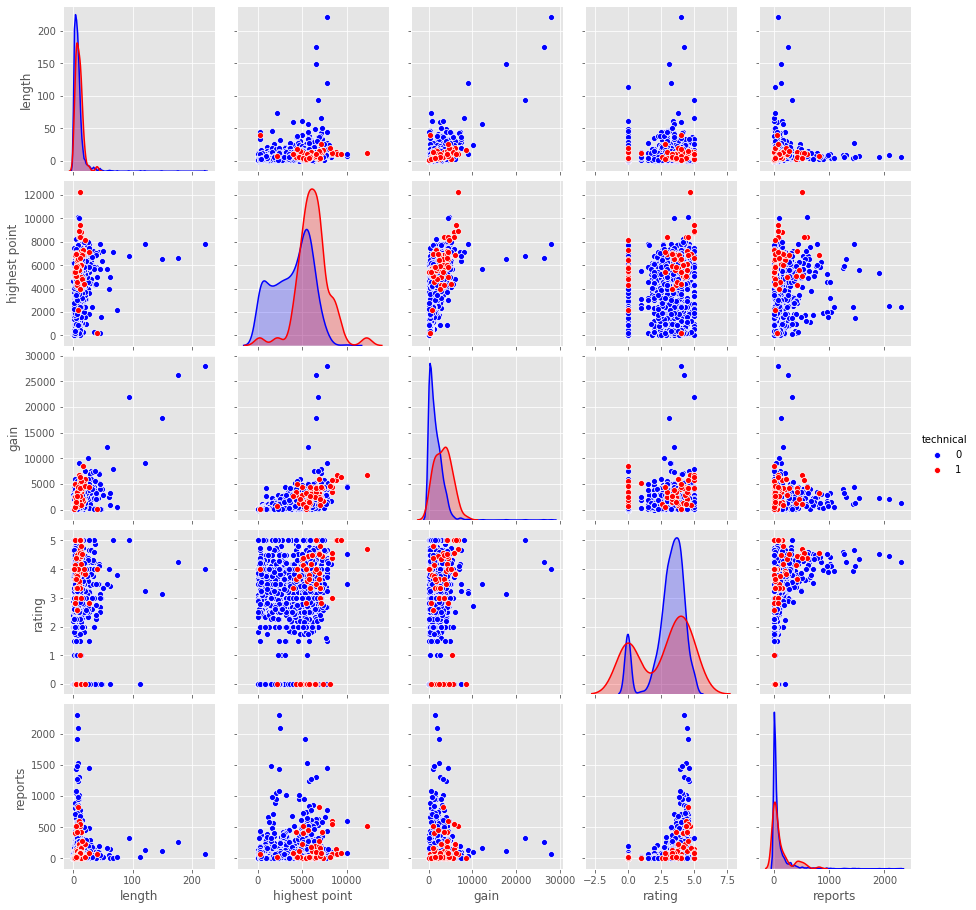

In [169]:
g = sns.pairplot(hikes_scatter, hue="technical", palette={0:'b',1:'r'})
g.savefig('../images/technical_scatter_matrix.png', dpi=300, bbox_inches='tight')